In [1]:
%matplotlib notebook

In [2]:
import numpy as np
from numpy import log, arctan2, pi, mean
from numpy.linalg import norm, solve
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import meshio
from bem import (assem, eval_sol, read_geo_gmsh,
                 rearrange_mats, rearrange_sol,
                 surf_plot, create_rhs)

Now, let us run a simulation.

In [3]:
mesh, coords, elems, x_m, y_m, id_dir, id_neu = read_geo_gmsh("files/disk.msh", [0, 1], [2, 3])
Gmat, Fmat = assem(coords, elems)

We can write the system of equations as

$$[G]\{q\} = [F]\{u\}\, .$$

Since we have mixed boundary conditions we can
split the vectors as 

$$\{q\} = \begin{Bmatrix}q_u\\ q_q\end{Bmatrix}\, ,\quad
\{u\} = \begin{Bmatrix}u_u\\ u_q\end{Bmatrix}\, ,$$

where the subscript $u$ denote elements with Dirichlet
boundary conditions and $q$ with Neumann boundary
conditions.

Thus, we can write the system as

$$\begin{bmatrix}
G_{uu} &G_{uq}\\
G_{qu} &G_{qq}
\end{bmatrix}\begin{Bmatrix}q_u\\ q_q\end{Bmatrix}
= \begin{bmatrix}
F_{uu} &F_{uq}\\
F_{qu} &F_{qq}
\end{bmatrix}\begin{Bmatrix}u_u\\ u_q\end{Bmatrix}\, ,
$$

or

\begin{align}
G_{uu} q_u + G_{uq} q_q = F_{uu} u_u + F_{uq} u_q\, ,\\
G_{qu} q_u + G_{qq} q_q = F_{qu} u_u + F_{qq} u_q\, .
\end{align}

We can rearrange this as

\begin{align}
G_{uu} q_u - F_{uq} q_q = F_{uu} u_u - G_{uq} u_q\, ,\\
G_{qu} q_u - F_{qq} q_q = F_{qu} u_u - G_{qq} u_q\, ,
\end{align}

or

$$\begin{bmatrix}
G_{uu} &-F_{uq}\\
G_{qu} &-F_{qq}
\end{bmatrix}\begin{Bmatrix}q_u\\ u_q\end{Bmatrix}
= \begin{bmatrix}
F_{uu} &-G_{uq}\\
F_{qu} &-G_{qq}
\end{bmatrix}\begin{Bmatrix}u_u\\ q_q\end{Bmatrix}\, ,
$$

where we have moved all unknowns to the left-hand side.



Following we create the arrays

In [4]:
A = np.zeros_like(Fmat)
B = np.zeros_like(Fmat)

In [5]:
A[np.ix_(id_dir, id_dir)] = Gmat[np.ix_(id_dir, id_dir)]
A[np.ix_(id_dir, id_neu)] = -Fmat[np.ix_(id_dir, id_neu)]
A[np.ix_(id_neu, id_dir)] = Gmat[np.ix_(id_neu, id_dir)]
A[np.ix_(id_neu, id_neu)] = -Fmat[np.ix_(id_neu, id_neu)]


In [6]:
B[np.ix_(id_dir, id_dir)] = Fmat[np.ix_(id_dir, id_dir)]
B[np.ix_(id_dir, id_neu)] = -Gmat[np.ix_(id_dir, id_neu)]
B[np.ix_(id_neu, id_dir)] = Fmat[np.ix_(id_neu, id_dir)]
B[np.ix_(id_neu, id_neu)] = -Gmat[np.ix_(id_neu, id_neu)]

And the vector of known values

In [7]:
theta = np.unwrap(np.arctan2(y_m, x_m))
rhs = np.zeros(elems.shape[0])
rhs[id_dir] = 3*np.cos(6*theta[id_dir])
rhs[id_neu] = -18*np.cos(6*theta[id_neu])

Solution

In [8]:
sol = solve(A, B.dot(rhs))

In [9]:
u_bound = np.zeros_like(sol)
q_bound = np.zeros_like(sol)
u_bound[id_dir] = rhs[id_dir]
u_bound[id_neu] = sol[id_neu]
q_bound[id_dir] = sol[id_dir]
q_bound[id_neu] = rhs[id_neu]

In [10]:
solution = eval_sol(mesh.points[:, :2], coords, elems, u_bound, q_bound)

Visualization

<IPython.core.display.Javascript object>


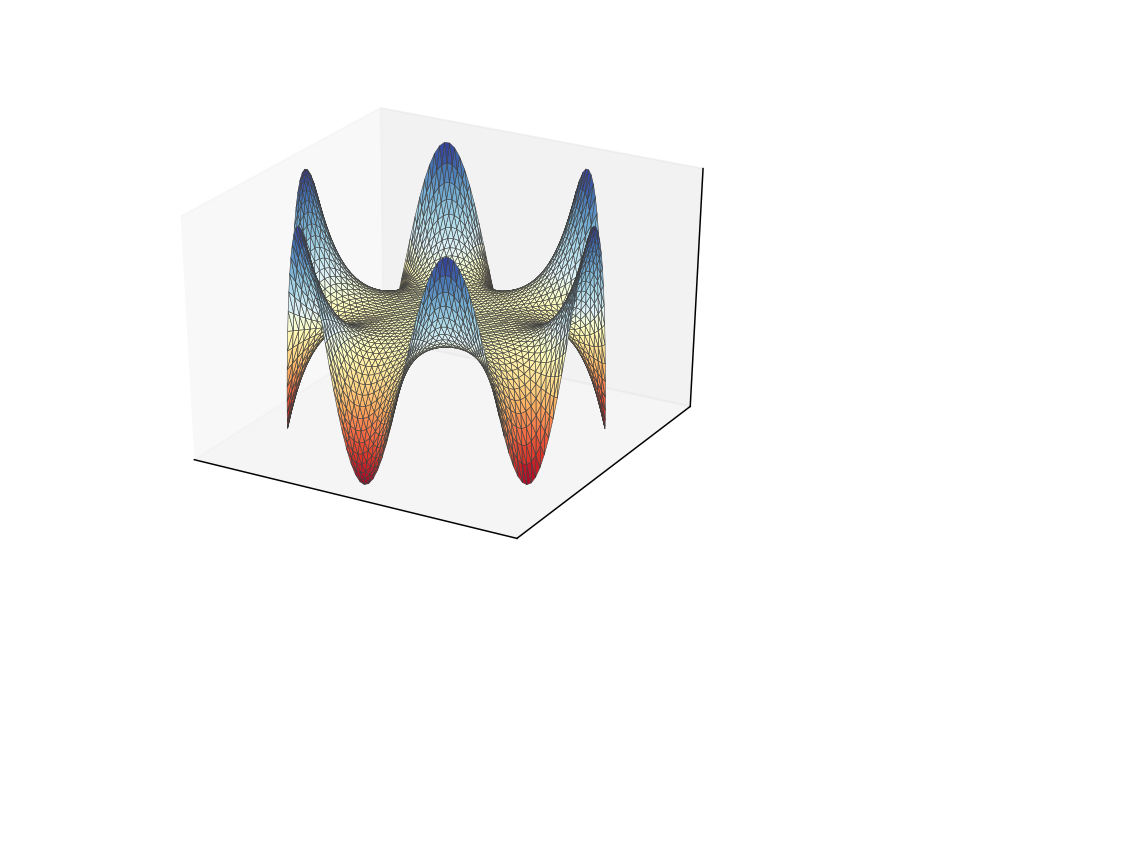

[]

In [11]:
ax = surf_plot(mesh, 4, solution)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])